In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary

import PIL
import shutil
import zipfile
import glob
import os
import time
import random
import timm
import tqdm

데이터 파싱

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataDir = './dataset/AI-DATASET/data'


trainData_dir = os.path.join(dataDir, 'trainData')
train_dir = os.path.join(dataDir, 'train')
test_dir = os.path.join(dataDir, 'test')

# beverage_can_dir = os.path.join(trainData_dir, 'beverage_can')
# beverage_bottle_files = os.path.join(trainData_dir, 'beverage_bottle')

beverage_can_files = [f'beverage_can.{i}.jpg' for i in range(1,  501)]
beverage_bottle_files = [f'beverage_bottle.{i}.jpg' for i in range(1,  501)]
noodle_cup_files  = [f'noodle_cup.{i}.jpg' for i in range(1,  501)]
noodle_bag_files  = [f'noodle_bag.{i}.jpg' for i in range(1,  501)]


# train, valid, test 폴더 생성

train_set_dir = os.path.join(train_dir, 'train')
# os.mkdir(train_set_dir)
valid_set_dir = os.path.join(train_dir, 'valid')
# os.mkdir(valid_set_dir)
test_set_dir = os.path.join(train_dir, 'test')
# os.mkdir(test_set_dir)

"""
for beverage_can, beverage_bottle, noodle_cup, noodle_bag in zip(beverage_can_files[:300], beverage_bottle_files[:300], noodle_cup_files[:300], noodle_bag_files[:300]):
    src = os.path.join(train_dir, beverage_can)
    dst = os.path.join(train_set_dir, beverage_can)
    shutil.move(src, dst)

    src = os.path.join(train_dir, beverage_bottle)
    dst = os.path.join(train_set_dir, beverage_bottle)
    shutil.move(src, dst)

    src =os.path.join(train_dir, noodle_cup)
    dst = os.path.join(train_set_dir, noodle_cup)
    shutil.move(src, dst)

    src = os.path.join(train_dir, noodle_bag)
    dst = os.path.join(train_set_dir, noodle_bag)
    shutil.move(src, dst)

for beverage_can, beverage_bottle, noodle_cup, noodle_bag in zip(beverage_can_files[300:400], beverage_bottle_files[300:400],noodle_cup_files[300:400], noodle_bag_files[300:400]):
    src = os.path.join(train_dir, beverage_can)
    dst = os.path.join(valid_set_dir, beverage_can)
    shutil.move(src, dst)

    src = os.path.join(train_dir, beverage_bottle)
    dst = os.path.join(valid_set_dir, beverage_bottle)
    shutil.move(src, dst)

    src =os.path.join(train_dir, noodle_cup)
    dst = os.path.join(train_set_dir, noodle_cup)
    shutil.move(src, dst)

    src = os.path.join(train_dir, noodle_bag)
    dst = os.path.join(train_set_dir, noodle_bag)
    shutil.move(src, dst)


for beverage_can, beverage_bottle, noodle_cup, noodle_bag in zip(beverage_can_files[400:500], beverage_bottle_files[400:500], noodle_cup_files[400:500], noodle_bag_files[400:500]):
    src = os.path.join(train_dir, beverage_can)
    dst = os.path.join(test_set_dir, beverage_can)
    shutil.move(src, dst)

    src = os.path.join(train_dir, beverage_bottle)
    dst = os.path.join(test_set_dir, beverage_bottle)
    shutil.move(src, dst)

    src =os.path.join(train_dir, noodle_cup)
    dst = os.path.join(train_set_dir, noodle_cup)
    shutil.move(src, dst)

    src = os.path.join(train_dir, noodle_bag)
    dst = os.path.join(train_set_dir, noodle_bag)
    shutil.move(src, dst)
"""

'\nfor beverage_can, beverage_bottle, noodle_cup, noodle_bag in zip(beverage_can_files[:300], beverage_bottle_files[:300], noodle_cup_files[:300], noodle_bag_files[:300]):\n    src = os.path.join(train_dir, beverage_can)\n    dst = os.path.join(train_set_dir, beverage_can)\n    shutil.move(src, dst)\n\n    src = os.path.join(train_dir, beverage_bottle)\n    dst = os.path.join(train_set_dir, beverage_bottle)\n    shutil.move(src, dst)\n\n    src =os.path.join(train_dir, noodle_cup)\n    dst = os.path.join(train_set_dir, noodle_cup)\n    shutil.move(src, dst)\n\n    src = os.path.join(train_dir, noodle_bag)\n    dst = os.path.join(train_set_dir, noodle_bag)\n    shutil.move(src, dst)\n\nfor beverage_can, beverage_bottle, noodle_cup, noodle_bag in zip(beverage_can_files[300:400], beverage_bottle_files[300:400],noodle_cup_files[300:400], noodle_bag_files[300:400]):\n    src = os.path.join(train_dir, beverage_can)\n    dst = os.path.join(valid_set_dir, beverage_can)\n    shutil.move(src, ds

In [21]:
def seed_everything(seed=42):
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything()

데이터셋 설정

In [22]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'beverage_can' in files[0]:
            self.label = 0
        elif 'beverage_bottle' in files[0]:
            self.label = 1
        elif 'noodle_bag' in files[0]:
            self.label = 2
        else:
            self.label = 3


    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

데이터 전처리

In [23]:

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])


transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.RandomCrop(224),
        torchvision.transforms.RandomRotation(degrees=(-10,10)),
        torchvision.transforms.RandomAffine(degrees=(-16, 16), translate=(.1,.1)),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])



train_beverage_can_dataset = CustomDataset(beverage_can_files[:300], train_set_dir, transform=transform)
train_beverage_bottle_dataset = CustomDataset(beverage_bottle_files[:300], train_set_dir, transform=transform)
train_noodle_cup_dataset = CustomDataset(noodle_cup_files[:300], train_set_dir, transform=transform)
train_noodle_bag_dataset = CustomDataset(noodle_bag_files[:300], train_set_dir, transform=transform)


valid_beverage_can_dataset = CustomDataset(beverage_can_files[300:400], valid_set_dir, transform=transform)
valid_beverage_bottle_dataset = CustomDataset(beverage_bottle_files[300:400], valid_set_dir, transform=transform)
valid_noodle_cup_dataset = CustomDataset(noodle_cup_files[300:400], train_set_dir, transform=transform)
valid_noodle_bag_dataset = CustomDataset(noodle_bag_files[300:400], train_set_dir, transform=transform)


test_beverage_can_dataset = CustomDataset(beverage_can_files[400:], test_set_dir, transform=transform)
test_beverage_bottle_dataset = CustomDataset(beverage_bottle_files[400:], test_set_dir, transform=transform)
test_noodle_cup_dataset = CustomDataset(noodle_cup_files[400:], train_set_dir, transform=transform)
test_noodle_bag_dataset = CustomDataset(noodle_bag_files[400:], train_set_dir, transform=transform )

 
train_dataset = torch.utils.data.ConcatDataset([train_beverage_can_dataset, train_beverage_bottle_dataset, train_noodle_cup_dataset, train_noodle_bag_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_beverage_can_dataset, valid_beverage_bottle_dataset, valid_noodle_cup_dataset, valid_noodle_bag_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_beverage_can_dataset, test_beverage_bottle_dataset, test_noodle_cup_dataset, test_noodle_bag_dataset])


print(f'number of train dataset : {len(train_dataset)}')
print(f'number of valid dataset : {len(valid_dataset)}')
print(f'number of test dataset : {len(test_dataset)}')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

number of train dataset : 1200
number of valid dataset : 400
number of test dataset : 400


사용할 모델

In [24]:
model = torchvision.models.resnet50(weights=True)

seed_everything()

num_classes = 4
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.to(device)

summary(model, input_size=(3,224,224))

c:\Users\kde96\.conda\envs\PyeonHaeng\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

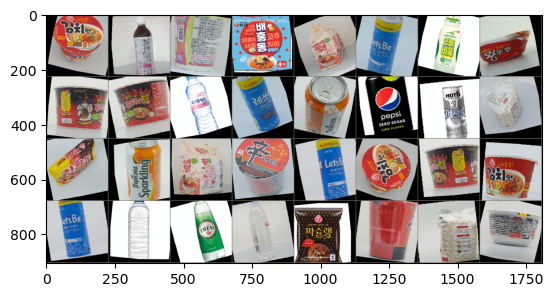

In [25]:
seed_everything()

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(train_loader))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out)


In [26]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        valid_loss = 0
        valid_correct = 0
        valid_total = 0
        
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device)
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * train_x.size(0)
            
            _, predicted = torch.max(pred.data, 1)
            train_total += train_y.size(0)
            train_correct += (predicted == train_y).sum().item()
        
        # validation data check
        with torch.no_grad():
            for valid_x, valid_y in valid_loader:
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device)
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
                valid_loss += loss.item() * valid_x.size(0)
                
                _, predicted = torch.max(pred.data, 1)
                valid_total += valid_y.size(0)
                valid_correct += (predicted == valid_y).sum().item()
        
        train_losses.append(train_loss/len(train_loader.dataset))
        train_accuracies.append(train_correct/train_total)
        valid_losses.append(valid_loss/len(valid_loader.dataset))
        valid_accuracies.append(valid_correct/valid_total)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader.dataset):.4f}, train acc: {train_correct/train_total*100:.3f}% / valid loss: {valid_loss/len(valid_loader.dataset):.4f}, valid acc: {valid_correct/valid_total*100:.3f}%')
        
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()
    
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

def eval(model, criterion, test_loader):
    model.eval()
    correct = 0
    losses = 0
    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device)
            pred = model(test_x)
            loss = criterion(pred, test_y)
            
            _, y_pred = torch.max(pred, 1)  # 다중분류의 경우, 가장 높은 확률을 가진 클래스를 예측값으로 선택합니다.
            
            losses += loss.item()
            correct += (y_pred == test_y).sum().item()
            
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')


In [27]:
seed_everything()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
 
fit(model, criterion, optimizer, 5, train_loader, valid_loader)
eval(model, criterion, test_loader)


RuntimeError: 0D or 1D target tensor expected, multi-target not supported